In [99]:
# ##@title Install requirements
# ! pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git
# ! pip install ipyplot
# ! pip install pytube
# ! pip install av

import ipyplot
import glob
import numpy as np
import os
import shutil

import av
import cv2
import clip
import torch
from tqdm import tqdm
from PIL import Image
from pytube import YouTube

device = "cuda" if torch.cuda.is_available() else "cpu"

In [100]:
# Founction
def save_all_frames(video_path, dir_path, basename, skip=1, ext='jpg'):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    n = 0
    while True:
        ret, frame = cap.read()
        if ret:
            if n % skip == 0:
                cv2.imwrite('{}_{}.{}'.format(base_path, str(n).zfill(digit), ext), frame)
            n += 1
        else:
            return

def detect(frames):
    for frame in tqdm(frames):
        try:
            results = model_yolo(frame)
            results.crop(save_dir='./output')
        except:
            pass
    return [Image.open(f).convert('RGB') for f in glob.glob('./output/crops/**/*.jpg')]

def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x


In [113]:
# Download video from youtube and save as frames.
# center: iCl8RgG_7yA
# https://youtu.be/XPhND-lEgk0

video_id = {'center': 'iCl8RgG_7yA', 'far': 'XPhND-lEgk0', 'right': 'T0kOwctZ4ic', 'left': 'hcvf1LuPQMs', 'front': '5nAIADv1XJw'}
_type = "far"
id = video_id[_type]
video_url = f'https://www.youtube.com/watch?v={id}'

video_url = f'https://www.youtube.com/watch?v=XYAS5UtDmr8'

streams = YouTube(video_url).streams.filter(adaptive=True, subtype="mp4", resolution="720p", only_video=True)
streams[0].download(filename="video.mp4")

try:
    shutil.rmtree('./output')
except:
    pass
save_all_frames('video.mp4', './output', 'sample', skip=2)

files = sorted(glob.glob('./output/sample*'))


In [114]:
# Model YOLO
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x', force_reload=True)

# Data
im = []
for file in files:
    im.append(Image.open(file).convert('RGB'))
print(len(im))

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/xin/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-1-11 torch 1.10.1 CUDA:0 (NVIDIA RTX A6000, 48685MiB)

Fusing layers... 
Model Summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


108


In [115]:
# Get detection retsults
output_yolo = detect(im)

  0%|          | 0/108 [00:00<?, ?it/s]Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

  4%|▎         | 4/108 [00:00<00:03, 32.01it/s]Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

  7%|▋         | 8/108 [00:00<00:02, 33.89it/s]Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

 11%|█         | 12/108 [00:00<00:02, 35.41it/s]Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

Saved 1 image to output
Saved results to output

 15%|█▍        | 16/108 [00:00<00:0

Detected total 597 objects
0.001766


/home/xin/miniconda3/lib/python3.9/site-packages/ipyplot/_utils.py:95: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(seq, dtype=type(seq[0]))



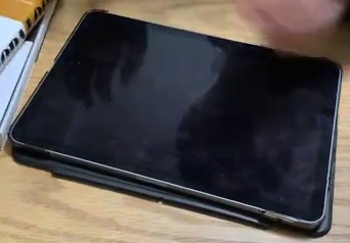


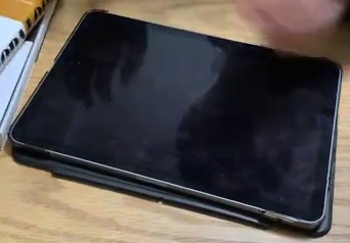

0.001758



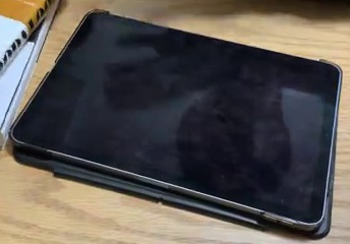


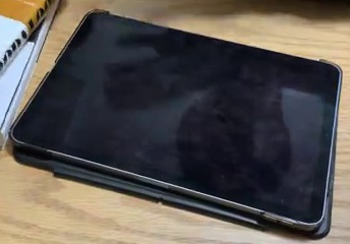

0.001754



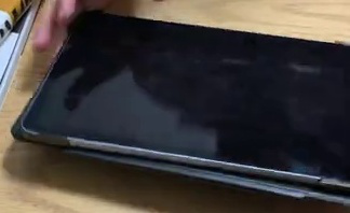


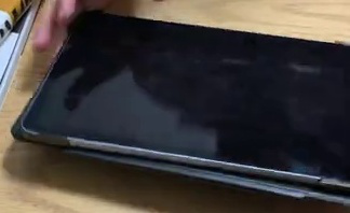

In [116]:
print(f'Detected total {len(output_yolo)} objects')

# CLIP to computer the PROMPT and apple crops.
model_clip, preprocess = clip.load("ViT-B/16", device=device)

PROMPT = "iphone"
images = torch.stack([preprocess(image) for image in output_yolo]).to(device)

with torch.no_grad():
    image_features = model_clip.encode_image(images)
    text_encoded = model_clip.encode_text(clip.tokenize(PROMPT).to(device))

image_features /= image_features.norm(dim=-1, keepdim=True)
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

similarity = text_encoded.cpu().numpy() @ image_features.cpu().numpy().T
similarity = softmax(similarity[0])
# print(similarity)
top = 3
indexs = np.argpartition(-np.array(similarity), top)[:top]
for i in indexs:
    # print(similarity[i]/ sum(similarity))
    print(similarity[i])
    ipyplot.plot_images(output_yolo[i:i+1], img_width=350)